In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter
import collections
from pandas import DataFrame
from scipy.cluster.hierarchy import linkage, dendrogram

from pyspark.ml.recommendation import ALS
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SQLContext, Row

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

# Import data

In [2]:
# personality scores
personality_score_table = pd.read_excel('data/pers_scores_1098.xlsx')
# articles by some traveler
article_table = pd.read_excel('data/articles_159.xlsx')
# traveler profile
profile_table = pd.read_excel('data/users_full_7034.xlsx')
# traveler and reviews
review_table = pd.read_excel('data/reviews_32618_for_1098_users_with_location.xlsx')


In [3]:
personality_score_table.head()

,username,open,cons,extra,agree,neuro
0,007solotraveler,0.63272,0.55666,0.56360,0.58108,0.45881
1,0BKI0,0.64006,0.55189,0.56220,0.57943,0.46188
2,10179k79,0.66435,0.56099,0.56880,0.58187,0.45011
3,124_10,0.66003,0.57005,0.57221,0.59019,0.44860
4,12ReasonsWhy,0.65036,0.55429,0.56510,0.58271,0.45919


In [4]:
article_table.head()

,username,date,title,text,total_points
0,19katy80,2012-07-15,Why come to Manchester?,"Quite simply, whatever your interest, Manchest...",5
1,29grapes,2010-03-27,Taxis in Shanghai,Taxi companies in Shanghai are heavily regulat...,5
2,ALiEN2108,2011-11-03,Arriving & Departing,Airport Transfer FAQs answered:\nThere are two...,5
3,ASK_THE_LEYLANDS,2010-11-09,"HEYSEN AND MAWSON TRAILS, AUSTRALIA",Laura is small township situated in the Sout...,100
4,Alfanumeric,2013-12-06,Neighborhoods,City Centre\nWhile Americans cousins refer to ...,5


In [105]:
profile_table.head(15)

,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
0,007solotraveler,35-49,male,liverpool,NaN,Contributor,2010-06-01,10.0,1.0,1.0,NaN,6.0,NaN,NaN,NaN,8.0,1240.0,3,10
1,0BKI0,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",Contributor,2009-08-01,11.0,7.0,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
2,1010101,NaN,NaN,uk,NaN,NaN,2009-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0
3,10179k79,NaN,NaN,"Berlin, Germany",NaN,Top Contributor,2008-05-01,54.0,1.0,NaN,3.0,2.0,8.0,NaN,NaN,48.0,5808.0,5,58
4,10onwoodford,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5,124_10,NaN,NaN,"Perth, Australia","Like a Local, Luxury Traveller, Peace and Quie...",Contributor,2010-10-01,9.0,1.0,1.0,NaN,3.0,NaN,NaN,NaN,10.0,1119.0,3,4
6,12ReasonsWhy,NaN,NaN,Manchester,NaN,Senior Reviewer,2008-08-01,5.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,8.0,802.0,2,2
7,14beacon,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",Contributor,2009-03-01,7.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14
8,150NightsPerYear,35-49,male,Wisconsin,NaN,Senior Contributor,2008-05-01,15.0,12.0,6.0,4.0,221.0,1.0,NaN,NaN,20.0,4471.0,4,36
9,1771,35-49,female,Kentucky,NaN,Senior Contributor,2009-08-01,12.0,9.0,NaN,2.0,NaN,NaN,NaN,NaN,18.0,2111.0,3,11


In [6]:
review_table.head()

,id,username,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,1,007solotraveler,Hotels,2013-04-08,Good Choice and would be suitable for a family,Decent Hotel next to station so good location ...,4,1.0,101,"Radisson Blu Royal Viking Hotel, Stockholm",http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm
1,2,007solotraveler,Hotels,2013-04-08,Modern and Chic - suitable both family and bus...,Excellent Hotel - well situated for getting ro...,5,0.0,100,Radisson Blu Waterfront Hotel,http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm
2,3,007solotraveler,Attractions,2013-02-20,Brilliant - Well worth a visit(s),Great Museum - abslutely worth making the time...,5,1.0,101,Vasa Museum,http://www.tripadvisor.com/Attraction_Review-g...,Stockholm
3,4,007solotraveler,Hotels,2012-07-09,Family stay,Stayed for 3 nights in MIami - stayed here due...,4,0.0,100,Hilton Miami Airport,http://www.tripadvisor.com/Hotel_Review-g34438...,Miami
4,5,007solotraveler,Restaurants,2011-09-07,Great Prime Rib!,I always visit Hunters when in San Diego. The ...,5,1.0,101,Hunter Steakhouse,http://www.tripadvisor.com/Restaurant_Review-g...,San Diego


__Aggregate city sub-ratings based on username__ 
<br>
(ex. 
<br>
from: 
<br>
UserA - London - Hotel X - 5
<br>
UserA - London - Hotel Y - 4
<br>
UserA - London - Hotel Z - 3
<br>
to:
<br>
UserA - London - Hotel - 4)


In [9]:
df = pd.DataFrame([['A', 'Hotel', 3, 'China'],
                  ['A', 'Hotel', 6, 'China'],
                  ['A', 'Hotel', 9, 'China'],
                  ['B', 'Attrat', 5, 'China'],
                  ['B', 'Attrat', 9, 'China'],
                  ['B', 'Hotel', 9, 'China'],
                  ['B', 'Hotel', 1, 'US'], 
                  ['B', 'Hotel', 9, 'US'], 
                  ['A', 'Rest', 2, 'US'],
                  ['A', 'Rest', 7, 'US'],
                  ['A', 'Rest', 9, 'Canada']],
                  columns=['user', 'type', 'rating','city'])

In [10]:
df

,user,type,rating,city
0,A,Hotel,3,China
1,A,Hotel,6,China
2,A,Hotel,9,China
3,B,Attrat,5,China
4,B,Attrat,9,China
5,B,Hotel,9,China
6,B,Hotel,1,US
7,B,Hotel,9,US
8,A,Rest,2,US
9,A,Rest,7,US


In [26]:
newdf1 = df.groupby(['user','city','type']).mean()
newdf2 = df.groupby(['user','city']).mean()

In [39]:
newdf1

rating
user city   type          
A    Canada Rest       9.0
     China  Hotel      6.0
     US     Rest       4.5
B    China  Attrat     7.0
            Hotel      9.0
     US     Hotel      5.0

create weight average for each categories and generate the overall rating

In [80]:
#weighting_dict

weight_dict = {'Rest':0.1, 'Attrat':0.8, 'Hotel':0.1}



In [81]:
for us in newdf1.index.get_level_values('user').unique():
#     print(newdf1.loc[us])
    temp_df_1 = newdf1.loc[us]
    for cntry in temp_df_1.index.get_level_values('city').unique():
        temp_df_2 = temp_df_1.loc[cntry]
        divisor = 0 
        running_rating = 0 
        for typ in temp_df_2.index.get_level_values('type'):
#             print(temp_df_2.index)
            running_rating += weight_dict[typ]*temp_df_2.loc[typ]
            divisor+=weight_dict[typ]
#             print(running_rating)
        running_rating/=divisor
        print(running_rating, (us, cntry))

rating    9.0
Name: Rest, dtype: float64 ('A', 'Canada')
rating    6.0
Name: Hotel, dtype: float64 ('A', 'China')
rating    4.5
Name: Rest, dtype: float64 ('A', 'US')
rating    7.222222
Name: Attrat, dtype: float64 ('B', 'China')
rating    5.0
Name: Hotel, dtype: float64 ('B', 'US')


## filter out users with no agerange or travelstyle

In [100]:
null_total = profile_table.travelStyle.isnull().sum()
null_total


3532

In [91]:
null_age = profile_table.ageRange.isnull().sum()
null_age

2248

In [101]:
profile_table.shape

(7034, 19)

In [92]:
null_age/7034

0.31959056013647996

In [104]:
(null_total/7034)

0.5021324992891669

In [28]:
newdf2

rating
user city            
A    Canada  9.000000
     China   6.000000
     US      4.500000
B    China   7.666667
     US      5.000000

## grouping users and cities, return rating

In [82]:
review_table_1 = review_table.groupby(['username','taObjectCity', 'type']).agg({'rating': 'mean'})


In [83]:
review_table_1

rating
username    taObjectCity        type                 
422         Barnstaple          Hotels       4.000000
            Benalmadena         Hotels       4.000000
            Birmingham          Hotels       5.000000
            Bristol             Hotels       5.000000
            Chichester          Hotels       4.000000
            Congresbury         Hotels       4.000000
            Dubai               Attractions  5.000000
                                Hotels       5.000000
            Dundee              Hotels       5.000000
            Edinburgh           Hotels       5.000000
            Fort Lauderdale     Hotels       5.000000
            Fremington          Hotels       5.000000
            Gatwick             Hotels       4.800000
            Kingham             Hotels       5.000000
            Lancaster           Hotels       2.500000
            Leeds               Hotels       5.000000
            Lille               Hotels       5.000000
            Llucmajor           Hotels       4.000000
            London              Hotels       4.833333
            Luton               Hotels       5.000000
            Magny-le-Hongre     Hotels       2.000000
            Manchester          Hotels       3.500000
            Melrose             Hotels       5.000000
            Monte-Carlo         Hotels       5.000000
            New Smyrna Beach    Hotels       5.000000
            New York City       Hotels       4.000000
            Newcastle upon Tyne Hotels       4.000000
            Olhao               Attractions  4.000000
                                Hotels       5.000000
                                Restaurants  5.000000
...                                               ...
Farnborough Bournemouth         Hotels       3.000000
                                Restaurants  5.000000
            Bruges              Restaurants  3.000000
            Calder Grove        Hotels       3.000000
            Camberley           Restaurants  1.000000
            Cambridge           Hotels       3.000000
            Chamonix            Hotels       5.000000
                                Restaurants  4.000000
            Eastbourne          Hotels       5.000000
                                Restaurants  4.000000
            Farnborough         Restaurants  3.250000
            Fleet               Restaurants  2.000000
            Ghent               Hotels       4.000000
                                Restaurants  4.500000
            Guildford           Restaurants  5.000000
            Haarlem             Restaurants  4.500000
            Hameln              Hotels       4.000000
            Hamm                Hotels       4.000000
            Krakow              Hotels       3.000000
            Leuven              Hotels       5.000000
            London              Restaurants  4.000000
            Moniga del Garda    Restaurants  4.200000
            Norwich             Attractions  1.500000
                                Restaurants  4.000000
            Potsdam             Attractions  5.000000
                                Hotels       5.000000
                                Restaurants  5.000000
            Troyes              Hotels       5.000000
            Zandvoort           Hotels       5.000000
                                Restaurants  5.000000

[23303 rows x 1 columns]

In [45]:
sum(data3.numHotelsReviews.isnull())
na_hotel = data3.numHotelsReviews.isnull()

In [46]:
sum(data3.numRestReviews.isnull())
na_rest = data3.numRestReviews.isnull()

In [47]:
sum(data3.numAttractReviews.isnull());
na_attract = data3.numAttractReviews.isnull()

In [58]:
sum(data3.numHelpfulVotes.isnull())
#na_help = data3.numHelpfulVotes.isnull()

0

In [228]:
newdata3 = data3[~na_hotel][~na_rest][~na_attract]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [229]:
newdata3.head()

,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
0,007solotraveler,35-49,male,liverpool,NaN,Contributor,2010-06-01,10.0,1.0,1.0,NaN,6.0,NaN,NaN,NaN,8.0,1240.0,3,10
5,124_10,NaN,NaN,"Perth, Australia","Like a Local, Luxury Traveller, Peace and Quie...",Contributor,2010-10-01,9.0,1.0,1.0,NaN,3.0,NaN,NaN,NaN,10.0,1119.0,3,4
6,12ReasonsWhy,NaN,NaN,Manchester,NaN,Senior Reviewer,2008-08-01,5.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,8.0,802.0,2,2
7,14beacon,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",Contributor,2009-03-01,7.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14
8,150NightsPerYear,35-49,male,Wisconsin,NaN,Senior Contributor,2008-05-01,15.0,12.0,6.0,4.0,221.0,1.0,NaN,NaN,20.0,4471.0,4,36


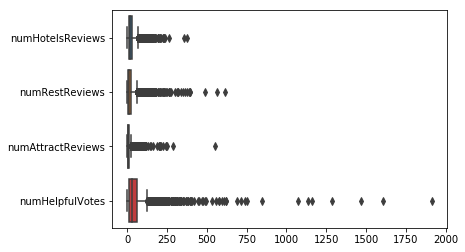

In [59]:
sns.boxplot(data=newdata3[['numHotelsReviews', 'numRestReviews', 'numAttractReviews', 'numHelpfulVotes']], orient="h");

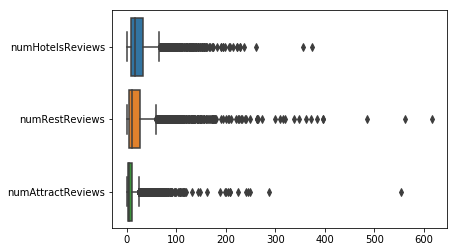

In [50]:
sns.boxplot(data=newdata3[['numHotelsReviews', 'numRestReviews', 'numAttractReviews']], orient="h");


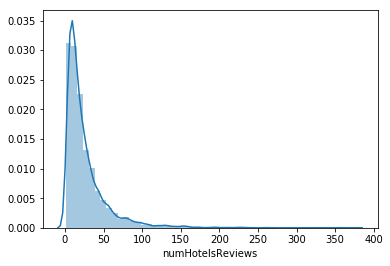

In [55]:
sns.distplot(newdata3['numHotelsReviews']);

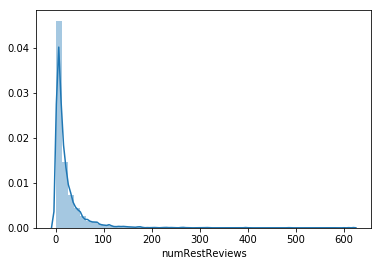

In [56]:
sns.distplot(newdata3['numRestReviews']);

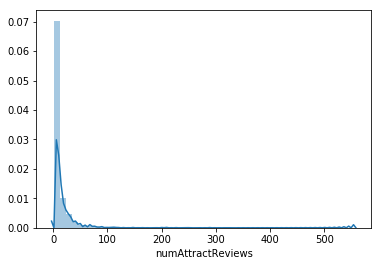

In [57]:
sns.distplot(newdata3['numAttractReviews']);

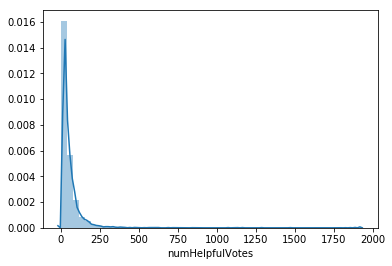

In [60]:
sns.distplot(newdata3['numHelpfulVotes']);

In [230]:
newdata3['numHelpfulVotes'].describe()

count    4513.000000
mean       49.147574
std        82.231631
min         0.000000
25%        13.000000
50%        28.000000
75%        58.000000
max      1912.000000
Name: numHelpfulVotes, dtype: float64

In [231]:
helpful_mask = newdata3['numHelpfulVotes'] >= 13

In [232]:
newdata3 = newdata3[helpful_mask].sort_values(by = 'numHelpfulVotes', ascending = False)

In [233]:
newdata3.shape

(3473, 19)

In [200]:
topcontri = data4.username == 'JamesII'

In [201]:
data4[topcontri]

,id,username,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity


In [202]:
data1[data1.username == 'DRDerbyshire']

,username,open,cons,extra,agree,neuro
810,DRDerbyshire,0.6489,0.55415,0.56379,0.57897,0.4621


In [203]:
data1.shape

(1098, 6)

In [223]:
newdata3.shape
# shape 2233 when helpfulness >= 28 and 3473 when >= 13

(2233, 19)

In [234]:
merged_table = data1.merge(newdata3, on = 'username')

In [235]:
merged_table.shape

(519, 24)

In [236]:
merged_table.sort_values(by = 'numHelpfulVotes', ascending = False)

,username,open,cons,extra,agree,neuro,ageRange,gender,location,travelStyle,...,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
258,CJTravelerTexas,0.65769,0.56359,0.56796,0.58143,0.45202,65+,male,Texas,"Foodie, Like a Local, 60+ Traveler, History Bu...",...,241.0,217.0,1002.0,1986.0,NaN,NaN,155.0,159158.0,6,1468
73,Alfanumeric,0.64278,0.55840,0.56456,0.58283,0.46163,35-49,male,Scotland,Peace and Quiet Seeker,...,13.0,12.0,66.0,9.0,1136.0,6.0,47.0,38258.0,6,608
209,Bob1949,0.64608,0.55466,0.56566,0.58295,0.45890,65+,male,"Jersey, Channel Islands","Foodie, 60+ Traveler, Luxury Traveller",...,48.0,29.0,10.0,4.0,795.0,NaN,190.0,67051.0,6,576
490,Equity,0.64777,0.56062,0.56911,0.58972,0.45518,50-64,male,"Avon, CT","Foodie, History Buff, Nature Lover, Art and Ar...",...,59.0,86.0,1.0,NaN,26.0,NaN,156.0,41998.0,6,573
275,CanadianinMadrid,0.64379,0.55330,0.56320,0.57760,0.46219,50-64,male,"Baton Rouge, Louisiana","Beach Goer, History Buff, Urban Explorer, Luxu...",...,209.0,135.0,53.0,1209.0,200.0,9.0,159.0,89425.0,6,475
394,Darlox,0.65277,0.56545,0.57265,0.59065,0.44710,35-49,male,"Cleveland, Ohio",Foodie,...,3.0,11.0,2.0,NaN,32.0,NaN,79.0,10531.0,6,381
21,2Travelers2go,0.64840,0.55995,0.56835,0.58685,0.45411,NaN,NaN,DC Metro Area,NaN,...,36.0,55.0,NaN,140.0,240.0,NaN,82.0,29477.0,6,377
155,Badgerjim,0.65248,0.56153,0.56838,0.58388,0.45089,50-64,male,"Augusta, Maine","Eco-tourist, Like a Local, History Buff, Urban...",...,25.0,54.0,11.0,43.0,8.0,12.0,54.0,12856.0,6,331
395,DaveJC,0.64301,0.55838,0.56573,0.58431,0.45767,50-64,male,"Stowmarket, United Kingdom",NaN,...,76.0,23.0,13.0,268.0,1.0,NaN,128.0,30140.0,6,315
9,1NicePerson,0.65470,0.56117,0.56939,0.58548,0.45193,NaN,male,USA,"60+ Traveler, Like a Local, Urban Explorer, Th...",...,6.0,17.0,6.0,4.0,17.0,NaN,75.0,18996.0,6,306


In [253]:
reviews_table = merged_table.merge(data4, on = 'username')

In [257]:
reviews_table.sort_values(by = 'helpfulness', ascending = False)

,username,open,cons,extra,agree,neuro,ageRange,gender,location,travelStyle,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
19277,DrRingDing,0.65698,0.55695,0.56505,0.57726,0.45658,35-49,male,"Petit Roche, AR","History Buff, Urban Explorer",...,Hotels,2005-06-13,Great refueling station,"I&acute;ve stayed at this hotel several times,...",4,51.0,151,Vagabond Inn Executive Sacramento Old Town,http://www.tripadvisor.com/Hotel_Review-g32999...,Sacramento
17191,DaisyFred,0.64870,0.56078,0.56881,0.58936,0.45418,35-49,female,London,"Foodie, History Buff, Like a Local, Urban Expl...",...,Hotels,2006-11-05,like a palace & we were the royal guests,Abolutely brilliant -in fact I&acute;ve been p...,5,39.0,139,Jaz Lamaya Resort,http://www.tripadvisor.com/Hotel_Review-g31142...,Marsa Alam
20908,Emzaro,0.63816,0.56242,0.56886,0.59197,0.45904,35-49,female,Rhode Island,"Foodie, Beach Goer, History Buff, Nature Lover...",...,Restaurants,2013-08-25,Glad we found it!,Our family decided to drive from Pisa to Rome ...,5,38.0,138,Chicche e Pepe,http://www.tripadvisor.com/Restaurant_Review-g...,Tarquinia
3065,ASN1972,0.64001,0.55849,0.56631,0.58739,0.46212,35-49,female,"Alexandria, VA","Thrifty Traveller, Family Hoilday Maker, Art a...",...,Hotels,2004-06-12,Cozy little place by the beach,This is a great timeshare location. We had won...,5,36.0,136,Aruba Beach Club,http://www.tripadvisor.com/Hotel_Review-g14724...,Palm - Eagle Beach
15776,Corpito,0.64704,0.56280,0.56848,0.58554,0.45542,35-49,male,"Corpus Christi, TX",Family Hoilday Maker,...,Hotels,2006-07-29,A Wonderful Trip,"Our age: Upper 20s\nHome: Corpus Christi, TX\n...",5,36.0,136,Golden Crown Paradise Resort Puerto Vallarta,http://www.tripadvisor.com/Hotel_Review-g15079...,Puerto Vallarta
333,19katy80,0.64480,0.55656,0.56650,0.58612,0.45836,25-34,female,"Manchester, United Kingdom",NaN,...,Hotels,2006-07-05,Good value for money,La Piramide is in Costa Antigua (fna Nuevo Hor...,3,36.0,136,Aparthotel Horizonte Bay,http://www.tripadvisor.com/Hotel_Review-g26205...,Fustes
1317,2Travelers2go,0.64840,0.55995,0.56835,0.58685,0.45411,NaN,NaN,DC Metro Area,NaN,...,Hotels,2006-10-19,Bugged about Bellows,After many years of rave reviews about the mil...,2,35.0,135,Bellows Air Force Station,http://www.tripadvisor.com/Hotel_Review-g60662...,Waimanalo
16792,DJH-in-Austin,0.64213,0.56088,0.56923,0.59012,0.45483,NaN,NaN,Austin,NaN,...,Hotels,2005-03-21,Relaxing Classic Hotel - Some Tolerance Required,"First, if you are looking for a vacation in a ...",4,33.0,133,Arlington Resort Hotel & Spa,http://www.tripadvisor.com/Hotel_Review-g60856...,Hot Springs
1326,2Travelers2go,0.64840,0.55995,0.56835,0.58685,0.45411,NaN,NaN,DC Metro Area,NaN,...,Hotels,2005-10-17,El Dorado Seaside - Not worth it,I can honestly tell you that after traveling a...,1,33.0,133,"El Dorado Seaside Suites, by Karisma",http://www.tripadvisor.com/Hotel_Review-g15351...,Puerto Aventuras
4481,Alfanumeric,0.64278,0.55840,0.56456,0.58283,0.46163,35-49,male,Scotland,Peace and Quiet Seeker,...,Hotels,2012-03-16,Abysmal !,Myself and a colleague stayed for one night du...,1,28.0,128,Hilton Dartford Bridge,http://www.tripadvisor.com/Hotel_Review-g18705...,Dartford


In [259]:
sum(reviews_table.helpfulness.isnull())

5986

In [260]:
reviews_table.shape

(22358, 35)

In [261]:
print(''5986/22358)

0.2677341443778513

In [238]:
reviews_table.taObjectCity.nunique()

4613

In [239]:
reviews_table = reviews_table[['username','taObjectCity']]

In [240]:
reviews_table.head(10)

,username,taObjectCity
0,14beacon,Charleston
1,14beacon,Farmingdale
2,14beacon,Poughkeepsie
3,14beacon,Mount Pocono
4,14beacon,Beacon
5,14beacon,Beacon
6,14beacon,North Charleston
7,14beacon,New York City
8,14beacon,Mystic
9,14beacon,Deptford


In [251]:
reviews_table.shape

(22358, 2)

In [241]:
reviews_new = reviews_table.groupby('taObjectCity').count()

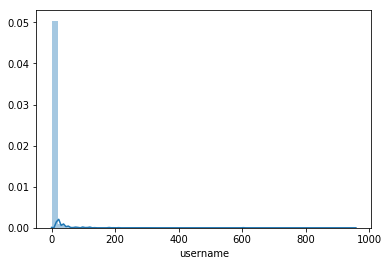

In [242]:
sns.distplot(reviews_new.username)

In [243]:
reviews_new.sort_values(by = 'username', ascending = False)

,username
taObjectCity,
London,957
New York City,605
Paris,280
Las Vegas,261
Chicago,213
Rome,191
Orlando,182
Singapore,180
San Francisco,160


removed popular cities: London, New York, Paris, Las Vegas that have more than 150 reviews 

In [244]:
sampe = reviews_new[reviews_new.username < 300].sort_values(by = 'username', ascending = False)

In [245]:
sampe = sampe[sampe.username > 50]

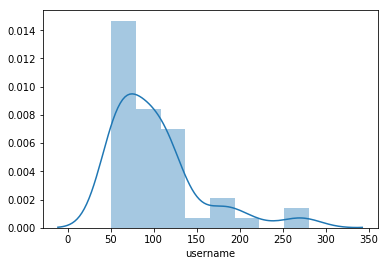

In [246]:
sns.distplot(sampe.username)

In [247]:
sampe

,username
taObjectCity,
Paris,280
Las Vegas,261
Chicago,213
Rome,191
Orlando,182
Singapore,180
San Francisco,160
Los Angeles,134
Washington DC,126


In [249]:
sampe.shape

(50, 1)

In [250]:
sampe['ones'] = 1
sampe.groupby(['taObjectCity','username']).count()

,,ones
taObjectCity,username,
Amsterdam,108,1
Anaheim,71,1
Atlanta,58,1
Bangkok,95,1
Barcelona,122,1
Belfast,52,1
Berlin,86,1
Birmingham,69,1
Boston,98,1


In [124]:
d = Counter(reviews_table.taObjectCity)

In [128]:
sorted_d = sorted((v,k) for k,v in d.items())

In [129]:
sorted_d

[(1, 'Aachen'),
 (1, 'Aamby Valley City'),
 (1, 'Aarhus'),
 (1, 'Aberaeron'),
 (1, 'Abergavenny'),
 (1, 'Abersoch'),
 (1, 'Abilene'),
 (1, 'Acworth'),
 (1, 'Adderbury'),
 (1, 'Addo'),
 (1, 'Adeje'),
 (1, 'Agawam'),
 (1, 'Agerola'),
 (1, 'Agia Triada'),
 (1, 'Agropoli'),
 (1, 'Aguas Calientes'),
 (1, 'Aheloy'),
 (1, 'Airlie Beach'),
 (1, 'Al Municipality'),
 (1, 'Alajuela'),
 (1, 'Alanya'),
 (1, 'Albert'),
 (1, 'Albert Lea'),
 (1, 'Albion'),
 (1, 'Alcala'),
 (1, 'Alderbury'),
 (1, 'Alderley Edge'),
 (1, 'Aldershot'),
 (1, 'Algarve'),
 (1, 'Alibaug'),
 (1, 'Alicante Province'),
 (1, 'Alipore'),
 (1, 'Allen'),
 (1, 'Allendale'),
 (1, 'Allenspark'),
 (1, 'Almaty'),
 (1, 'Alsip'),
 (1, 'Altavilla Vicentina'),
 (1, 'Amagansett'),
 (1, 'Amargosa Valley'),
 (1, 'Amboise'),
 (1, 'Amersfoort'),
 (1, 'Amport'),
 (1, 'Andalsnes'),
 (1, 'Andechs'),
 (1, 'Angels Camp'),
 (1, 'Angers'),
 (1, 'Annalong'),
 (1, 'Annandale'),
 (1, 'Anse Volbert'),
 (1, 'Antalya'),
 (1, 'Anuradhapura'),
 (1, 'Ao Phang Ng

In [112]:
cities_table.aggregate

0                   Gilbert
1                   Gilbert
2                   Gilbert
3                   Gilbert
4                   Phoenix
5                   Phoenix
6                 San Diego
7                 San Diego
8                 San Diego
9               San Antonio
10            Fort Stockton
11                Grayslake
12                Green Bay
13                Green Bay
14                Green Bay
15                     Mesa
16             Grand Rapids
17                  Gilbert
18              Grants Pass
19                 Appleton
20                  Madurai
21                 Appleton
22                 Appleton
23       Tremblay-En-France
24                New Delhi
25                    Seoul
26                    Seoul
27               Ronkonkoma
28            East Elmhurst
29                  Ginowan
                ...        
16856              Chamonix
16857         Bad Krozingen
16858         Bad Krozingen
16859                Troyes
16860      Moniga de

In [6]:
data4.head(1)

,id,username,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,1,007solotraveler,Hotels,2013-04-08,Good Choice and would be suitable for a family,Decent Hotel next to station so good location ...,4,1.0,101,"Radisson Blu Royal Viking Hotel, Stockholm",http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm


# EDA
## data2 - articles

In [7]:
data2.text[8];

In [8]:
data2.head(10);

In [9]:
Counter(data3.numAttractReviews);

In [10]:
Counter(data4.type)

Counter({'Attractions': 5010, 'Hotels': 16699, 'Restaurants': 10871})

In [11]:
len(data4.taObjectCity.unique())

5927

In [12]:
Counter(data2.total_points)

Counter({5: 87, 100: 72})

## data3

In [13]:
#plt(data3.totalPoints);
import pylab
null_total_pt = data3.totalPoints.isnull()
#plt.hist(data3.totalPoints[~null_total_pt]);
#pylab.xlim([0,300000])
max_pt = data3.totalPoints[~null_total_pt].max()
max_pt
#plt.hist(data3.totalPoints[~null_total_pt].drop([5162]))
#max_2 = data3.totalPoints[~null_total_pt].drop([5162]).max()
#max_2
#plt.hist(data3.totalPoints[~null_total_pt].drop([5162,4829]);
#plt.hist( 1000 < data3.totalPoints[~null_total_pt] < 60000)

352444.0

In [14]:
data3.totalPoints[~null_total_pt].sort_values()[::-1];

In [15]:




# outlier - 352444.0 tripadvisor points
data3[data3.totalPoints == max_pt]

,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
5162,jonotennis,35-49,male,NaN,NaN,Top Contributor,2011-02-01,90.0,179.0,198.0,51.0,2.0,10169.0,2.0,NaN,204.0,352444.0,6,619


In [16]:
# outlier - 236336.0 tripadvisor points
#data3[data3.totalPoints == max_2]

In [17]:
data3[data3.reviewerBadge == 'Top Contributor'];

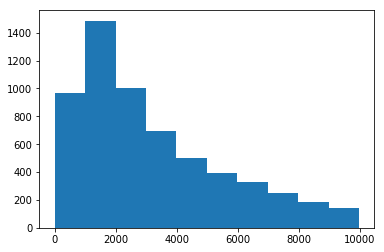

In [18]:
upper = (data3.totalPoints < 10000)
lower = (data3.totalPoints > 1000)
plt.hist(data3[upper].totalPoints);
#data3[upper].totalPoints

In [19]:
null_age = data3.ageRange.isnull()
null_gender = data3.gender.isnull()
null_style = data3.travelStyle.isnull()
#null

In [20]:
(data3[null_age].totalPoints < 1000).sum()

477

# data3 with no null age, gender, style, numAttractReviews

# data3 with total tripadvisor point > 1000 and no null age or gender

In [24]:
filtered_data3 = data3[data3.totalPoints > 1000][~null_age][~null_gender][~null_style]
filtered_data3.sort_values(by='numAttractReviews').head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
3569,Valerie16,50-64,female,"San Francisco, California","Beach Goer, Trendsetter, Urban Explorer, Thrif...",Contributor,2004-10-01,4.0,5.0,1.0,1.0,NaN,NaN,1.0,NaN,8.0,1026.0,3,6
903,Devon_girls,35-49,female,"London, United Kingdom","Foodie, Beach Goer",Top Contributor,2006-07-01,25.0,39.0,1.0,6.0,1.0,4.0,NaN,NaN,29.0,6690.0,5,65
899,Destichado,35-49,male,"Budapest, Hungary",Urban Explorer,Top Contributor,2008-12-01,58.0,1.0,1.0,10.0,72.0,4.0,15.0,NaN,52.0,6829.0,5,49
894,Derman23,25-34,male,Reading,"Foodie, Family Hoilday Maker",Contributor,2009-12-01,8.0,4.0,1.0,1.0,3.0,NaN,NaN,NaN,10.0,1320.0,3,5
3641,WayneLeeds_UK,35-49,male,"Leeds, UK","Beach Goer, Like a Local, Luxury Traveller, Fa...",Senior Contributor,2008-04-01,9.0,18.0,1.0,2.0,NaN,12.0,NaN,NaN,16.0,3179.0,4,19


In [23]:
data3[data3.totalPoints > 1000][~null_age][~null_gender][~null_style].shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2523, 19)

In [24]:
data3.numHelpfulVotes;

In [25]:
#Counter(data3.travelStyle.split(','))
data3.travelStyle.isnull().sum();
data3.travelStyle[~null_style].shape

styles_lst = []
for style in list(data3.travelStyle[data3.totalPoints > 1000][~null_age][~null_gender][~null_style]):
    item = style.split(', ')
    styles_lst.append(item)
    #print(styles)
    #styles_lst.extend(item)
    #print(styles_lst)
    
#print(styles_lst[:10])
newlist = [item for items in styles_lst for item in items]
Counter(newlist);
#print(len(Counter(newlist).keys()))
#scatter_matrix(Counter(newlist))


In [26]:
veg_lst = []
for item in styles_lst:
    if 'Vegetarian' in item:
        if len(item) < 4:
            veg_lst.append(item)
veg_lst[:10];


In [27]:
data3.travelStyle[~null_style].shape

(3502,)

## creating new column of list of travel styles

In [28]:
test_data3 = data3[data3.totalPoints > 1000][~null_style][~null_age][~null_gender]
#test_data3
#test_data3['new_travel_style'] = test_data3.travelStyle
#df = pd.get_dummies(test_data3, columns=['travelStyle'])
#df
style_lst2 = [item.split(', ') for item in test_data3.travelStyle]
style_lst2;
test_data3.shape


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2523, 19)

In [29]:
test_data3['new_travel'] = style_lst2
#test_data3.new_travel
test_data3;
#df = pd.get_dummies(test_data3, columns=['new_travel'])
#df



## creating dummies for each travel style

In [30]:
travel_style = test_data3['new_travel'].apply(pd.Series) # 653 notes
travel_style_matrix = pd.get_dummies(travel_style.apply(pd.Series).stack()). \
sum(level=0).rename(columns = lambda x : 'travel_style_' + x)


In [31]:
travel_style_matrix.columns

Index(['travel_style_60+ Traveler', 'travel_style_Art and Architecture Lover',
       'travel_style_Backpacker', 'travel_style_Beach Goer',
       'travel_style_Eco-tourist', 'travel_style_Family Hoilday Maker',
       'travel_style_Foodie', 'travel_style_History Buff',
       'travel_style_Like a Local', 'travel_style_Luxury Traveller',
       'travel_style_Nature Lover', 'travel_style_Nightlife Seeker',
       'travel_style_Peace and Quiet Seeker', 'travel_style_Shopping Fanatic',
       'travel_style_Thrifty Traveller', 'travel_style_Thrill Seeker',
       'travel_style_Trendsetter', 'travel_style_Urban Explorer',
       'travel_style_Vegetarian'],
      dtype='object')

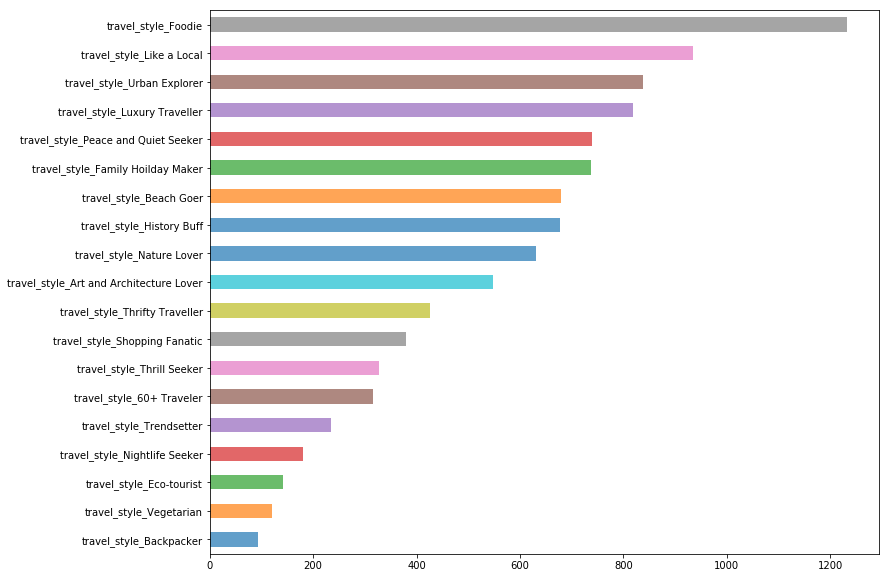

In [32]:
(travel_style_matrix.sum(axis=0)
                   .sort_values(ascending=True)
                   .plot(kind='barh',
                         figsize=(12,10),
                         alpha = .7));

In [33]:
travel_style_matrix;

In [35]:
#travel_style_matrix['travel_style_Luxury Traveller'].intersection(travel_style_matrix['travel_style_Shopping Fanatic'])

In [36]:
mask = travel_style_matrix

In [37]:
Counter(data3.contribLevel)

Counter({0: 85, 1: 17, 2: 943, 3: 2034, 4: 1655, 5: 1301, 6: 999})

# data 4 by reviews

In [28]:
data4.head()

,id,username,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,1,007solotraveler,Hotels,2013-04-08,Good Choice and would be suitable for a family,Decent Hotel next to station so good location ...,4,1.0,101,"Radisson Blu Royal Viking Hotel, Stockholm",http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm
1,2,007solotraveler,Hotels,2013-04-08,Modern and Chic - suitable both family and bus...,Excellent Hotel - well situated for getting ro...,5,0.0,100,Radisson Blu Waterfront Hotel,http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm
2,3,007solotraveler,Attractions,2013-02-20,Brilliant - Well worth a visit(s),Great Museum - abslutely worth making the time...,5,1.0,101,Vasa Museum,http://www.tripadvisor.com/Attraction_Review-g...,Stockholm
3,4,007solotraveler,Hotels,2012-07-09,Family stay,Stayed for 3 nights in MIami - stayed here due...,4,0.0,100,Hilton Miami Airport,http://www.tripadvisor.com/Hotel_Review-g34438...,Miami
4,5,007solotraveler,Restaurants,2011-09-07,Great Prime Rib!,I always visit Hunters when in San Diego. The ...,5,1.0,101,Hunter Steakhouse,http://www.tripadvisor.com/Restaurant_Review-g...,San Diego


In [38]:
mask = data4.username == '19katy80'
mask2 = data4.username == '1984travel'

In [39]:
new_mask = data4[mask].taObjectCity == 'Manchester'

In [40]:
data4[mask][new_mask];

In [41]:
bongo_mask = data4.username == 'Bongo_Craigy'

In [42]:
data4[bongo_mask].taObjectCity;

In [43]:
attrac_mask = data4.type == 'Attractions'
data4[attrac_mask][mask2];

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## data 1 - personality


In [44]:
data1_new = data1.drop(['username'], axis = 1);
data1_new.head()
#scatter_matrix(data1_new, figsize=(16, 12));

,open,cons,extra,agree,neuro
0,0.63272,0.55666,0.56360,0.58108,0.45881
1,0.64006,0.55189,0.56220,0.57943,0.46188
2,0.66435,0.56099,0.56880,0.58187,0.45011
3,0.66003,0.57005,0.57221,0.59019,0.44860
4,0.65036,0.55429,0.56510,0.58271,0.45919


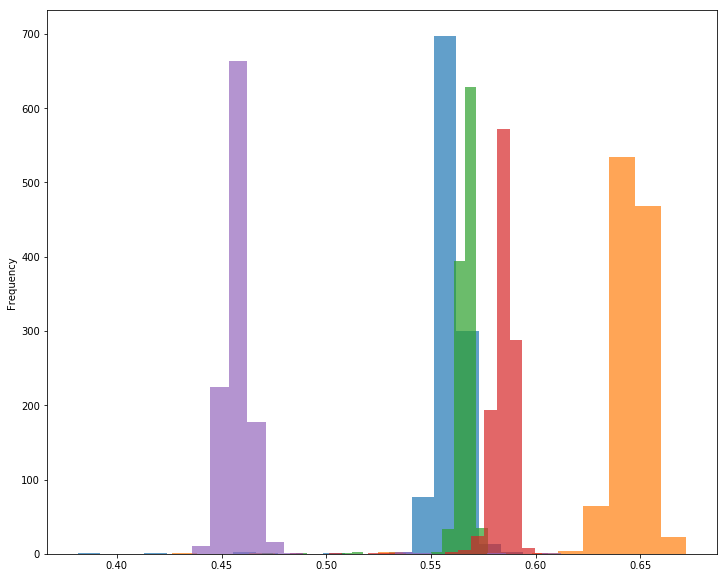

In [45]:
data1_new['cons'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_new['open'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_new['extra'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_new['agree'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_new['neuro'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);


# merging data1 - personality and data3- reviews

In [46]:
data1_and_3 = pd.merge(data1, filtered_data3, on=['username'])
data1_and_3.head(2)


,username,open,cons,extra,agree,neuro,ageRange,gender,location,travelStyle,...,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
0,0BKI0,0.64006,0.55189,0.56220,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
1,14beacon,0.64359,0.56584,0.56965,0.59001,0.45454,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",...,2.0,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14


In [47]:
final_table = pd.merge(data1_and_3, data4, on=['username'])
final_table.head(2)

,username,open,cons,extra,agree,neuro,ageRange,gender,location,travelStyle,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,0BKI0,0.64006,0.55189,0.5622,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,Restaurants,2015-09-28,Unhygienic & terrible service,I have visited this restaurant twice before an...,1,0.0,100,Wahaca Bristol,http://www.tripadvisor.com/Restaurant_Review-g...,Bristol
1,0BKI0,0.64006,0.55189,0.5622,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,Restaurants,2015-06-30,Beautiful resturant overlooking the beach and ...,If you are in Alvor you must visit Canico! Bea...,5,1.0,101,Canico Restaurant,http://www.tripadvisor.com/Restaurant_Review-g...,Alvor


In [48]:
final_table.type.unique();

In [49]:
attra_mask_final = final_table.type == 'Attractions'

In [50]:
final_table_2 = final_table[attra_mask_final]


In [51]:
final_table_2.columns.values

array(['username', 'open', 'cons', 'extra', 'agree', 'neuro', 'ageRange',
       'gender', 'location', 'travelStyle', 'reviewerBadge',
       'registerDate', 'numHotelsReviews', 'numRestReviews',
       'numAttractReviews', 'numFirstToReview', 'numRatings', 'numPhotos',
       'numForumPosts', 'numArticles', 'numCitiesBeen', 'totalPoints',
       'contribLevel', 'numHelpfulVotes', 'id', 'type', 'date', 'title',
       'text', 'rating', 'helpfulness', 'total_points', 'taObject',
       'taObjectUrl', 'taObjectCity'], dtype=object)

In [52]:
final_table_2.shape;

# 109 cities have more than 4 reviews

In [53]:
#Counter(final_table_2.taObjectCity).values() > 2
pop_city = []
for item, value in Counter(final_table_2.taObjectCity).items():
    if value > 4:
        pop_city.append(item)
len(pop_city)
print(pop_city)

['Berlin', 'London', 'Kuala Lumpur', 'Brussels', 'Darwin', 'Chattanooga', 'St. Petersburg', 'Vienna', 'Athens', 'Granada', 'Barcelona', 'Madrid', 'Canberra', 'Washington DC', 'New York City', 'Montreal', 'Budapest', 'Santa Barbara', 'Sydney', 'Hanoi', 'Rome', 'Nashville', 'San Francisco', 'Dubai', 'Calgary', 'Quebec City', 'Chicago', 'Orlando', 'Anaheim', 'Lucerne', 'Amsterdam', 'Honolulu', 'Cologne', 'Paris', 'Monterey', 'Las Vegas', 'Boston', 'Yellowstone National Park', 'Bangkok', 'Lahaina', 'Helsinki', 'Hong Kong', 'Munich', 'Singapore', 'Vatican City', 'San Juan', 'Stratford-upon-Avon', 'Niagara Falls', 'Florence', 'Tallinn', 'Nice', 'Oxford', 'Reykjavik', 'Bergen', 'Venice', 'Key West', 'Atlanta', 'Miami', 'Los Angeles', 'Edinburgh', 'Belfast', 'Minato', 'Seattle', 'Brighton', 'Sentosa Island', 'Sao Paulo', 'Rio de Janeiro', 'Buenos Aires', 'Prague', 'Istanbul', 'Oslo', 'Manchester', 'Salzburg', 'Toronto', 'Naples', 'Lancaster', 'Moscow', 'Milan', 'Monte-Carlo', 'Hoi An', 'Warsaw

# group by cities then run NLP and then create city clusters

In [54]:
final_table_3 = final_table_2[final_table_2.taObjectCity.isin(pop_city)]
#df[~df.Species.isin(['Cat'])]

In [55]:
final_table_3 = final_table_3.reset_index()
final_table_3.head()
#final_table_3.shape

,index,username,open,cons,extra,agree,neuro,ageRange,gender,location,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,61,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,See it before its gone,The box is only a temporary exhibit while cons...,4,0.0,100,Humboldt Box,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
1,62,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,0.0,100,Neues Museum,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
2,77,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-11-09,Fantastic,"After reading all the hype about this show, I ...",5,0.0,100,The Book of Mormon London,http://www.tripadvisor.com/Attraction_Review-g...,London
3,113,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-01-27,Tranquility in a busy city,Sited within the main botanical gardens area o...,4,0.0,100,Orchid Park (Taman Orkid),http://www.tripadvisor.com/Attraction_Review-g...,Kuala Lumpur
4,131,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2012-06-25,"Tourist trap, some nice architecture",Not a lot to say. It&acute;s a big plaza. Not ...,3,1.0,101,Grand-Place,http://www.tripadvisor.com/Attraction_Review-g...,Brussels


In [56]:
#final_table_3.taObjectCity

In [57]:
reviews = final_table_3.title + ' ' + final_table_3.text
content = [i for i in reviews]
#content[:2]

In [58]:
def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(stop_words=('english'),
                                 max_features = 500,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    vectors = tfidf_model.toarray()
    cols = vectorizer.get_feature_names()
    
    #print(vectors[0][100:200])
    #print(cols[100:190])
    return (vectors, cols)
    
#     km_model = KMeans(n_clusters=clusters)
#     km_model.fit(tfidf_model)
 
#     clustering = collections.defaultdict(list)
 
#     for idx, label in enumerate(km_model.labels_):
#         clustering[label].append(idx)
 
#     return clustering
def _cluster(vectors, cols, texts):
    """
    Cluster vecotirzed reviews and create k books a data frame relating the
    k label to the book id
    """
    kmeans = KMeans(n_clusters=5).fit(vectors)
    k_books = pd.DataFrame(list(zip(list(kmeans.labels_),
                                list(texts.index))),
                                columns=['k_label', 'book_id'])
    
    ''' added code to print centriod vocab - Print the top n words from all centroids vocab
    '''
    n = 30
    centroids = kmeans.cluster_centers_
    for ind, c in enumerate(centroids):
        print(ind)
        indices = c.argsort()[-1:-n-1:-1]
        print([cols[i] for i in indices])
        print("=="*20)
    
    return k_books

In [59]:
#from pprint import pprint
vector, cols = cluster_texts(content, 5)
cluster_df = _cluster(vector, cols, reviews)

0
['para', 'da', 'em', 'um', 'local', 'central', 'hotel', 'shows', 'enjoy', 'disney', 'grand', 'chance', 'stand', 'exhibition', 'visitors', 'rock', 'exhibits', 'park', 'huge', 'center', 'shopping', 'little', 'time', 'falls', 'souvenirs', '20', 'place', '30', 'city', 'acute']
1
['worth', 'visit', 'good', 'just', 'walk', 'time', 'beautiful', 'building', 'amazing', 'view', 'day', 'really', 'interesting', 'views', 'museum', 'acute', 'people', 'experience', 'inside', 'nice', 'city', 'like', 'history', 'best', 'tickets', 'area', 'bridge', 'way', 'impressive', 'collection']
2
['great', 'place', 'nice', 'park', 'lovely', 'beautiful', 'fun', 'visit', 'acute', 'food', 'lots', 'good', 'loved', 'shops', 'excellent', 'area', 'day', 'old', 'walk', 'time', 'really', 'walking', 'enjoyed', 'view', 'just', 'town', 'night', 'spend', 'restaurants', 'enjoy']
3
['tour', 'guide', 'acute', 'good', 'bus', 'fun', 'really', 'great', 'time', 'city', 'day', 'tours', 'did', 'interesting', 'history', 'way', 'knowled

In [60]:
cluster_df.head(10);
#cluster_df.shape

In [61]:
cluster2_mask = (cluster_df['k_label'] == 2)
cluster0_mask = (cluster_df['k_label'] == 0)
cluster3_mask = (cluster_df['k_label'] == 3)
#cluster2_mask

In [62]:
#cluster_df[cluster2_mask].head(20);
#cluster_df[cluster0_mask][:-10];
cluster_df[cluster3_mask][100:120];

In [63]:
# from cluster 2
final_table_3.iloc[[0, 5, 6, 9, 15, 17]];
# Berlin, Darwin, London

# from cluster 0
final_table_3.iloc[[278, 279, 280, 611, 612, 986, 987]]
# Sao Paulo, Quebec City, Rio de Janeiro, Orlando

# from cluster 3
final_table_3.iloc[[229, 230, 233, 300, 971, 1039, 1115]];
# Atlanta, Niagara Falls, Bergen, New York City, Las Vegas, Reykjavik

In [64]:
# def print_centroid_vocab(self, n):
#     """
#     Print the top n words from all centroids vocab
#     """
#     centroids = self.kmeans.cluster_centers_
#     for ind, c in enumerate(centroids):
#         print(ind)
#         indices = c.argsort()[-1:-n-1:-1]
#         print([self.cols[i] for i in indices])
#         print("=="*20)

# ALS model?

## create spark dataframe

In [65]:
# Build our Spark Session and Context

spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc
sqlContext = SQLContext(sc)

In [66]:
#ratings_df = spark.createDataFrame(.drop('timestamp', axis=1))

In [67]:
np.linalg.svd?


In [68]:
final_table_3.head()

,index,username,open,cons,extra,agree,neuro,ageRange,gender,location,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,61,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,See it before its gone,The box is only a temporary exhibit while cons...,4,0.0,100,Humboldt Box,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
1,62,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,0.0,100,Neues Museum,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
2,77,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-11-09,Fantastic,"After reading all the hype about this show, I ...",5,0.0,100,The Book of Mormon London,http://www.tripadvisor.com/Attraction_Review-g...,London
3,113,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-01-27,Tranquility in a busy city,Sited within the main botanical gardens area o...,4,0.0,100,Orchid Park (Taman Orkid),http://www.tripadvisor.com/Attraction_Review-g...,Kuala Lumpur
4,131,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2012-06-25,"Tourist trap, some nice architecture",Not a lot to say. It&acute;s a big plaza. Not ...,3,1.0,101,Grand-Place,http://www.tripadvisor.com/Attraction_Review-g...,Brussels


In [69]:
temp_rdd = final_table_3[['username', 'taObjectCity', 'rating']]

In [70]:
temp_rdd;

In [71]:
len(temp_rdd.username.unique())

234

## creating user dictionary with key = user, values = id/index

In [72]:

user_dict = {}
for idx, user in enumerate(temp_rdd.username.unique()):
    user_dict[user] = idx
    
user_dict;
    

In [73]:
user_id_list = [user_dict[item] 
                  for user in temp_rdd.username for item, key in user_dict.items() 
                  if item == user]

In [74]:
temp_rdd['user_id'] = user_id_list

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
temp_rdd.head()

,username,taObjectCity,rating,user_id
0,19Cam,Berlin,4,0
1,19Cam,Berlin,3,0
2,19Cam,London,5,0
3,19Cam,Kuala Lumpur,4,0
4,19Cam,Brussels,3,0


In [76]:
len(user_id_list) == len(temp_rdd.username)

True

In [77]:
len(temp_rdd.taObjectCity.unique())

109

## creating city dictionary with key = city, values =id/index

In [78]:
city_dict = {}
for idx, city in enumerate(temp_rdd.taObjectCity.unique()):
    city_dict[city] = idx
    
city_dict;

In [79]:
city_id_list_2 = [city_dict[item] for city in temp_rdd.taObjectCity 
                  for item, key in city_dict.items() if item == city]

In [80]:
# make sure each city has an id

len(temp_rdd.taObjectCity) == len(city_id_list_2)

True

In [81]:
temp_rdd.head(20);


In [82]:
# city_id_list = []
# for city in temp_rdd.taObjectCity :
#     #print(city)
#     for item, key in city_dict.items():
#         if item == city:
#             city_id_list.append(city_dict[item])
#             #print('item:', item, 'idx:',city_dict[item])



In [83]:
temp_rdd['city_id'] = city_id_list_2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
new_temp_rdd = temp_rdd[['user_id', 'city_id', 'rating']]
new_temp_rdd['rating_float'] = pd.to_numeric(new_temp_rdd.rating, downcast='float');
new_temp_rdd['rating_float']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0       4.0
1       3.0
2       5.0
3       4.0
4       3.0
5       5.0
6       2.0
7       4.0
8       5.0
9       3.0
10      5.0
11      5.0
12      5.0
13      5.0
14      5.0
15      4.0
16      4.0
17      4.0
18      5.0
19      5.0
20      2.0
21      3.0
22      4.0
23      5.0
24      4.0
25      4.0
26      5.0
27      5.0
28      4.0
29      5.0
       ... 
1244    5.0
1245    3.0
1246    5.0
1247    3.0
1248    5.0
1249    4.0
1250    5.0
1251    5.0
1252    5.0
1253    5.0
1254    4.0
1255    5.0
1256    5.0
1257    5.0
1258    5.0
1259    5.0
1260    5.0
1261    5.0
1262    5.0
1263    5.0
1264    4.0
1265    5.0
1266    5.0
1267    4.0
1268    4.0
1269    4.0
1270    2.0
1271    1.0
1272    1.0
1273    2.0
Name: rating_float, Length: 1274, dtype: float32

In [85]:
new_temp_rdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 4 columns):
user_id         1274 non-null int64
city_id         1274 non-null int64
rating          1274 non-null int64
rating_float    1274 non-null float32
dtypes: float32(1), int64(3)
memory usage: 34.9 KB


In [86]:
new_new_temp_rdd = new_temp_rdd[['user_id','city_id','rating_float']]

In [87]:
new_new_temp_rdd.head()

,user_id,city_id,rating_float
0,0,0,4.0
1,0,0,3.0
2,0,1,5.0
3,0,2,4.0
4,0,3,3.0


In [88]:
# schema = StructType( [ 
#     StructField('user', StringType(), True),
#     StructField('city', StringType(), True),
#     StructField('rating', IntegerType(), True)]
# )

schema = StructType( [ 
    StructField('user', IntegerType(), True),
    StructField('city', IntegerType(), True),
    StructField('rating', FloatType(), True)]
)

In [89]:
sp_df = sqlContext.createDataFrame(new_new_temp_rdd, schema)
sp_df.take(10);


In [90]:
type(sp_df)

pyspark.sql.dataframe.DataFrame

In [91]:
#ratings_df = spark.createDataFrame(sp_df, schema)


In [92]:
train, test = sp_df.randomSplit([0.8, 0.2], seed=427471138)
train.show(10);

+----+----+------+
|user|city|rating|
+----+----+------+
|   0|   0|   4.0|
|   0|   1|   5.0|
|   0|   2|   4.0|
|   1|   4|   3.0|
|   1|   4|   5.0|
|   1|   4|   5.0|
|   2|   5|   5.0|
|   2|   5|   5.0|
|   2|   5|   5.0|
|   2|   6|   5.0|
+----+----+------+
only showing top 10 rows



# ALS model!!!!

In [93]:
als_model = ALS(userCol='user',
                itemCol='city',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=20
               )

In [94]:
recommender = als_model.fit(train)
recommender

ALS_475ba9925a855bae928f

In [95]:
predictions = recommender.transform(test)


In [96]:
predictions.show(20)

+----+----+------+----------+
|user|city|rating|prediction|
+----+----+------+----------+
| 102|  31|   5.0|   4.99757|
|  75|  31|   4.0|  4.932624|
|  75|  31|   4.0|  4.932624|
|  11|  31|   4.0|       NaN|
|  11|  31|   5.0|       NaN|
| 186|  31|   4.0| 3.1562424|
| 186|  31|   4.0| 3.1562424|
| 217|  85|   5.0| 4.4304533|
|  77|  85|   5.0|  4.741751|
|  37|  65|   4.0| 4.4578276|
| 175|  65|   4.0| 4.9368014|
|  92|  53|   5.0|  3.016919|
|  41|  53|   5.0| 4.7921405|
|  24|  53|   5.0|  3.594255|
| 131|  53|   5.0| 2.8895087|
| 221| 108|   5.0| 4.1495266|
| 199| 101|   4.0| 3.0166473|
| 115|  81|   5.0| 4.8759766|
| 232|  28|   4.0| 4.0046763|
|   9|  28|   4.0|  4.400531|
+----+----+------+----------+
only showing top 20 rows



In [97]:
col = predictions.rating-predictions.prediction

In [98]:
df_pred = predictions.toPandas()

In [99]:
pred = df_pred.prediction
actual = df_pred.rating

In [100]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, pred.fillna(3))

## mse 

In [101]:
print(np.sqrt(mse))

1.1116654


# hybrid recommender! - combo of utility matrix and user-only matrix

## user-only matrix

In [102]:
final_table_3.head(2)

,index,username,open,cons,extra,agree,neuro,ageRange,gender,location,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,61,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,See it before its gone,The box is only a temporary exhibit while cons...,4,0.0,100,Humboldt Box,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
1,62,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,0.0,100,Neues Museum,http://www.tripadvisor.com/Attraction_Review-g...,Berlin


In [103]:
final_table_3.columns

Index(['index', 'username', 'open', 'cons', 'extra', 'agree', 'neuro',
       'ageRange', 'gender', 'location', 'travelStyle', 'reviewerBadge',
       'registerDate', 'numHotelsReviews', 'numRestReviews',
       'numAttractReviews', 'numFirstToReview', 'numRatings', 'numPhotos',
       'numForumPosts', 'numArticles', 'numCitiesBeen', 'totalPoints',
       'contribLevel', 'numHelpfulVotes', 'id', 'type', 'date', 'title',
       'text', 'rating', 'helpfulness', 'total_points', 'taObject',
       'taObjectUrl', 'taObjectCity'],
      dtype='object')

In [104]:
user_feature_df = final_table_3[['index', 'username','ageRange', 'gender','travelStyle']]

In [105]:
travel_style_lst = [item.split(', ') for item in user_feature_df.travelStyle]
user_feature_df['new_travel'] = travel_style_lst

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [106]:
travel_style_revised = user_feature_df['new_travel'].apply(pd.Series) # 653 notes
travel_style_matrix_revised = pd.get_dummies(travel_style_revised.apply(pd.Series).stack()).sum(level=0).rename(columns = lambda x : 'travel_style_' + x)

In [107]:
travel_style_matrix_revised = travel_style_matrix_revised.drop(['travel_style_Foodie', 'travel_style_60+ Traveler'], axis=1)
travel_style_matrix_revised

,travel_style_Art and Architecture Lover,travel_style_Backpacker,travel_style_Beach Goer,travel_style_Eco-tourist,travel_style_Family Hoilday Maker,travel_style_History Buff,travel_style_Like a Local,travel_style_Luxury Traveller,travel_style_Nature Lover,travel_style_Nightlife Seeker,travel_style_Peace and Quiet Seeker,travel_style_Shopping Fanatic,travel_style_Thrifty Traveller,travel_style_Thrill Seeker,travel_style_Trendsetter,travel_style_Urban Explorer,travel_style_Vegetarian
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [108]:
#travel_style_matrix_revised.isnull()

In [109]:
# travel_style_matrix_revised['travel_style_Veg_or_eco'] = (travel_style_matrix_revised['travel_style_Vegetarian'] 
# + travel_style_matrix_revised['travel_style_Eco-tourist'])
# more_than_two_mask = travel_style_matrix_revised['travel_style_Veg_or_eco'] == 2

In [110]:
#travel_style_matrix_revised[more_than_two_mask]

In [111]:
mask = (travel_style_matrix_revised['travel_style_Nature Lover'] == 1) 
#| (travel_style_matrix_revised['travel_style_Eco-tourist'] == 1)

In [112]:
travel_style_matrix_revised[mask].sum()

travel_style_Art and Architecture Lover    174
travel_style_Backpacker                     19
travel_style_Beach Goer                    141
travel_style_Eco-tourist                    21
travel_style_Family Hoilday Maker          176
travel_style_History Buff                  200
travel_style_Like a Local                  262
travel_style_Luxury Traveller              107
travel_style_Nature Lover                  451
travel_style_Nightlife Seeker               35
travel_style_Peace and Quiet Seeker        146
travel_style_Shopping Fanatic              135
travel_style_Thrifty Traveller              93
travel_style_Thrill Seeker                 135
travel_style_Trendsetter                    54
travel_style_Urban Explorer                138
travel_style_Vegetarian                      8
dtype: int64

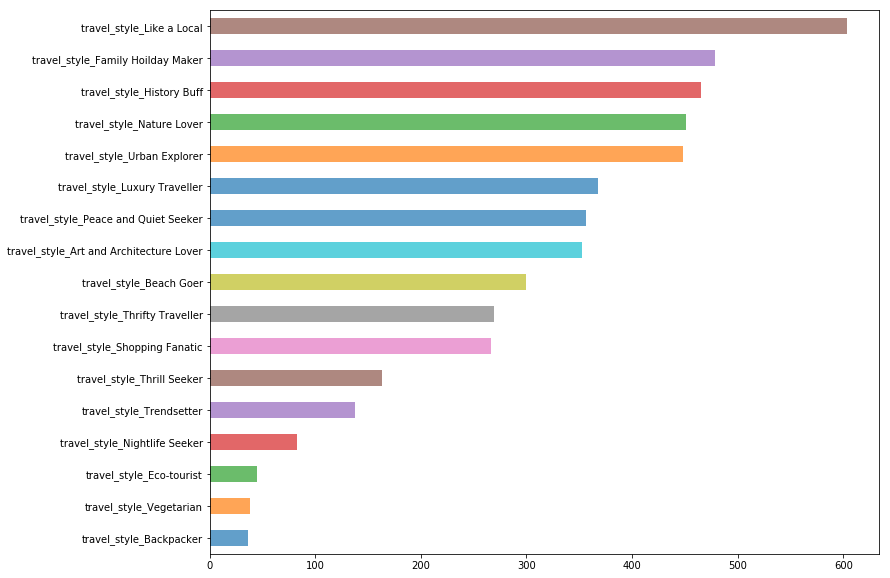

In [113]:
(travel_style_matrix_revised.sum(axis=0)
                   .sort_values(ascending=True)
                   .plot(kind='barh',
                         figsize=(12,10),
                         alpha = .7));

In [114]:
df_age_gender = final_table_3[['ageRange', 'gender']]
#df_age_gender.ageRange

In [115]:
df_age_gender = pd.get_dummies(df_age_gender, columns = ['ageRange'])

In [116]:
#df = pd.get_dummies(df, columns=['type'])


In [117]:
df_age_gender = pd.get_dummies(df_age_gender, columns = ['gender'])


In [118]:
left = df_age_gender
right = travel_style_matrix_revised

In [119]:
user_feat_df = left.join(right)

In [141]:
user_feat_df.shape

(1274, 24)

In [143]:
user_feat_df.shape

(1274, 24)

In [121]:
from sklearn.metrics import jaccard_similarity_score

In [122]:
user_feat_df_T = user_feat_df.T

In [123]:
jaccard_similarity_score(user_feat_df_T[0], user_feat_df_T[27])

0.6666666666666666

In [124]:
new_new_temp_rdd.head()

,user_id,city_id,rating_float
0,0,0,4.0
1,0,0,3.0
2,0,1,5.0
3,0,2,4.0
4,0,3,3.0


In [140]:
user_temp = new_new_temp_rdd[['user_id']]

df_user_id = pd.DataFrame(user_temp.user_id.unique(),columns=['user_id'])
df_user_id.head()

,user_id
0,0
1,1
2,2
3,3
4,4


# creating a matri

In [128]:
# filtered data number of unique cities
len(final_table_2.taObjectCity.unique())
#Counter(final_table[attra_mask_final].taObjectCity.unique())

1002

In [129]:
# original number of unique cities from data4
len(data4.taObjectCity.unique());

In [130]:
print(data1_new['cons'].mean())
print(data1_new['open'].mean())
print(data1_new['extra'].mean())
print(data1_new['agree'].mean())
print(data1_new['neuro'].mean())
print('----------filtered-------------')
print(data1_and_3['cons'].mean())
print(data1_and_3['open'].mean())
print(data1_and_3['extra'].mean())
print(data1_and_3['agree'].mean())
print(data1_and_3['neuro'].mean())

0.5588666575591985
0.6454380874316942
0.5664736976320587
0.5843303551912571
0.4581243078324227
----------filtered-------------
0.5585416452442162
0.6452703084832903
0.5661756298200515
0.583772673521851
0.4584064267352185


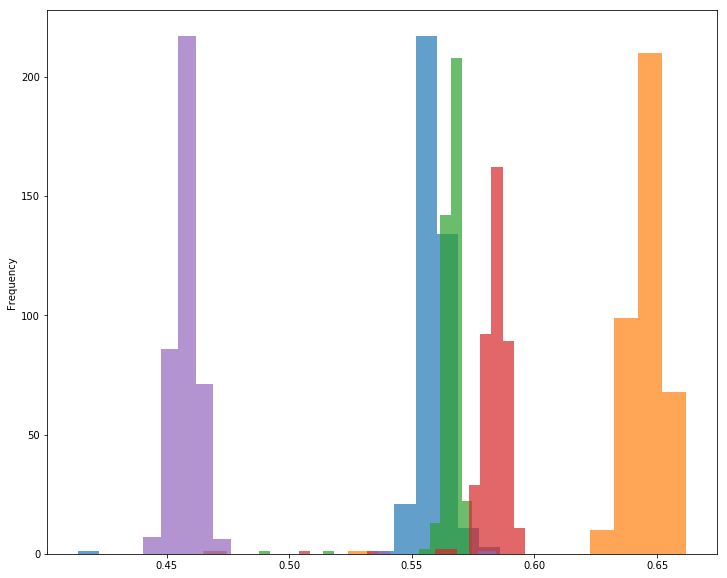

In [131]:

data1_and_3['cons'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_and_3['open'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_and_3['extra'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_and_3['agree'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_and_3['neuro'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);

# NLP

In [132]:
documents = data2.text[0].split('.')
cv = CountVectorizer(stop_words='english')
vectorized = cv.fit_transform(documents)

In [133]:
manchester_dict = cv.vocabulary_

In [134]:
documents2 = data2.text[1].split('.')
tfid2 = CountVectorizer(stop_words='english')
vectorized2 = tfid2.fit_transform(documents2)

In [135]:
features = tfid2.get_feature_names()
features;
#row = wiki_data.index.get_loc(name)

In [136]:
#vectorized2.shape
#d = pd.Series(vectorized2.toarray(), index = features)
#sort_values(ascending=False)
#vectorized2.toarray()
freqs = zip(tfid2.get_feature_names(), vectorized2.sum(axis=0))    
sorted(freqs, key=lambda x: -x[1]);

In [137]:
shanghai_dict = sorted(cv2.vocabulary_.items(), key = itemgetter(1), reverse = True)
#dct.items(), key=

NameError: name 'cv2' is not defined

In [ ]:
from collections import OrderedDict
from operator import itemgetter

In [ ]:
manchester_dict = sorted(cv.vocabulary_.items(), key = itemgetter(1), reverse = True)

In [ ]:
manchester_dict[:30];

In [ ]:
Counter(' '.join(documents).split()).most_common()[:30];